# GRAPH NODE SAMPLING

link : https://www.graphusergroup.com/graph-travel-2/  
paper : https://arxiv.org/abs/1607.00653?ref=graphusergroup.com


graph 모델에서 가장 근본 모델

In [2]:
# 필요한 모든 라이브러리 임포트
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import optuna
from sklearn.metrics import accuracy_score

# CORA 데이터셋 로드
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

# torch_geometric의 데이터를 NetworkX 그래프로 변환
edge_index = data.edge_index
edges = edge_index.t().numpy()
G = nx.from_edgelist(edges, create_using=nx.Graph())

/Users/kimtaejong/anaconda3/envs/base311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Node2Vec 이란?
- deep walk와 근본적으로 유사
- random walk와 word2vec 사용

### deep walk와의 차이점
- sampling 할때 bias 유무




## Sampling
1. 이전에 보았던 것과 비슷한 주변 노드들을 둘러보는 전략. 가장 가까운 노드를 먼저 방문하고 그 다음으로 가까운 노드를 방문하는 식으로 샘플링 : BFS
1. 이전에 본 적 없는 Node들을 둘러보는 전략. 한 방향으로 최대한 깊게 탐색하고, 더 이상 방문할 노드가 없으면 이전 노드로 돌아와 다른 방향을 탐색하는 식으로 샘플링 : DFS

### search bias probablity
- 두 개의 탐색 방법에서 적절하게 조율할 수 있다. 

- p : return parameter : 값이 높을수록 본 적 없는 새로운 노드를 탐색. 이 값이 크면 이전에 탐색한 노드로 돌아가는것을 방지하고 더 넓은 범위를 탐색 가능함
- q : in-out parameter : 타겟 노드의 이웃이 아닌 노드로 이동할 확률을 제어. 이 값이 크면 타겟 노드의 주변을 탐색하고, 작아지면 주변의 넓은 범위를 탐색하게 됨

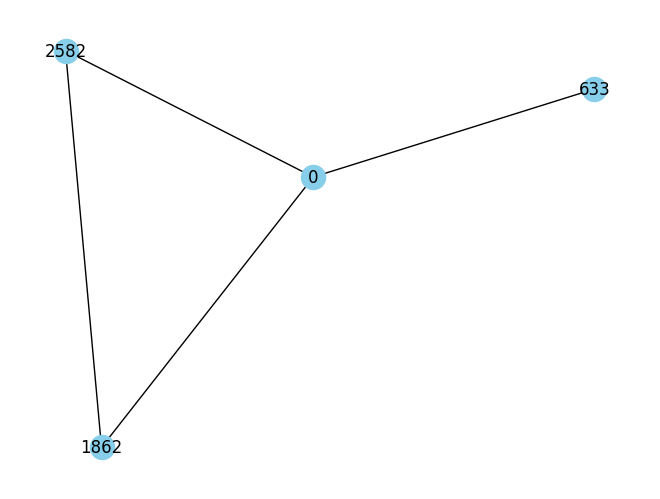

In [3]:
# torch_geometric의 데이터를 NetworkX 그래프로 변환
edge_index = data.edge_index
edges = edge_index.t().numpy()
graph_nx = nx.from_edgelist(edges, create_using=nx.Graph())

# 중심 노드를 선택 (여기서는 0을 선택)
center_nodes = [0]

# 모든 이웃 노드를 저장할 리스트 초기화
all_neighbors = []

# 중심 노드들의 모든 이웃 노드를 all_neighbors에 추가
for selected_node in center_nodes:
    neighbors = list(graph_nx.neighbors(selected_node))
    all_neighbors += neighbors

# 중심 노드들도 all_neighbors에 추가
all_neighbors += center_nodes

# all_neighbors에 포함된 모든 노드들만으로 구성된 subgraph를 추출
subgraph_nx1 = graph_nx.subgraph(all_neighbors)

# 그래프 그리기
pos = nx.spring_layout(subgraph_nx1, seed=42)  # Spring layout 사용
nx.draw(subgraph_nx1, pos, with_labels=True, node_color="skyblue")

plt.show()

- node 0이 고를 수 있는 선택지는 3가지네요. node 1862, node 2582, node 633 말이죠.
- 이때 파라미터 p가 높다면 : node 0 → node 1862로 되돌아갈 확률이 낮아집니다. 이 값이 높아질수록 walk는 DFS처럼 작동할 거에요.2. 이때 파라미터 q가 높다면 : node 0 → node 633으로 나아갈 확률이 높아집니다. 이 값이 높아질수록 walk는 BFS처럼 작동할 거에요.
- node 1682와 node 2582 사이에 edge가 있으므로, node 0 → node 2852로 나아갈 unnormalized probability는 1입니다. 다시 말해, random walk가 node 0로부터 node 2852로 이동할 확률은 1이에요. 이를 통해 이전 노드를 떠나 현재 노드 주변의 이웃을 탐색하도록 장려할 수 있죠.

## Social Network Concept

1. Structural Equivalence
- 두 개 이상의 노드가 유사한 연결 패턴을 가지고 있는지를 판단하는 데에 사용됩니다. 노드 A와 B의 neighbor nodes를 확인해 보았을 때, 겹치는 노드가 많다면 Structural Equivalent하다고 말할 수 있어요.
2. Homophily
- 비슷한 특성을 가진 노드들은 서로 연결될 가능성이 높다는 개념입니다. 노드 C와 D의 Attribute가 비슷하다면, 두 노드가 neighborhood일 가능성 (Edge로 연결되어 있을 가능성)이 높다고 말할 수 있어요.
3. 두 개념은 상호 배타적인가요?
- 전혀 아니랍니다! 두 가지 개념이 서로 연관될 수 있지만, 반드시 서로에게 직접적인 영향을 미치는 것은 아니거든요. 예를 들어, 동일한 선호나 취향을 가진다고 해서 그 두 사람이 비슷한 사회적 위치나 인간관계를 가지고 있어야 한다는 법은 없죠. 게다가 Graph의 특징에 따라 집중해야 하는 컨셉이 달라지기도 하고요.

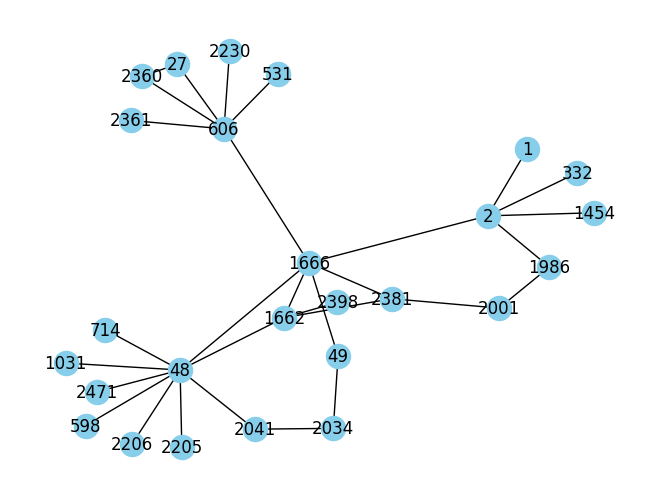

In [4]:
# torch_geometric의 데이터를 NetworkX 그래프로 변환
edge_index = data.edge_index
edges = edge_index.t().numpy()
graph_nx = nx.from_edgelist(edges, create_using=nx.Graph())

# 중심 노드를 선택 (여기서는 1666을 선택)
center_nodes = [1666]

# 모든 이웃 노드를 저장할 리스트 초기화
all_neighbors = []

# 중심 노드들의 모든 이웃 노드를 all_neighbors에 추가
for selected_node in center_nodes:
    neighbors = list(graph_nx.neighbors(selected_node))
    all_neighbors += neighbors

    # 이웃의 이웃(1차 이웃)도 all_neighbors에 추가
    for neighbor in neighbors:
        neighbors_of_neighbor = list(graph_nx.neighbors(neighbor))
        all_neighbors += neighbors_of_neighbor

# 중심 노드들도 all_neighbors에 추가
all_neighbors += center_nodes

# 중복을 제거하기 위해 all_neighbors를 set로 변환 후 다시 list로 변환
all_neighbors = list(set(all_neighbors))

# all_neighbors에 포함된 모든 노드들만으로 구성된 subgraph를 추출
subgraph_nx2 = graph_nx.subgraph(all_neighbors)

# 그래프 그리기
pos = nx.spring_layout(subgraph_nx2, seed=42)  # Spring layout 사용
nx.draw(subgraph_nx2, pos, with_labels=True, node_color="skyblue")

plt.show()

## Node2Vec 구현

In [5]:
# biased random walk 코드

import networkx as nx
import numpy as np
import random


def biased_random_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]

    while len(walk) < walk_length:
        cur_node = walk[-1]
        cur_neighbors = list(G.neighbors(cur_node))

        if len(cur_neighbors) > 0:
            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev_node = walk[-2]

                probability = []
                for neighbor in cur_neighbors:
                    if neighbor == prev_node:
                        # Return parameter
                        probability.append(1 / p)
                    elif G.has_edge(neighbor, prev_node):
                        # Stay parameter
                        probability.append(1)
                    else:
                        # In-out parameter
                        probability.append(1 / q)

                probability = np.array(probability)
                probability = probability / probability.sum()  # normalize

                next_node = np.random.choice(cur_neighbors, p=probability)
                walk.append(next_node)
        else:
            break

    return walk


def generate_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # to ensure randomness
        for node in nodes:
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return walks

In [6]:
generate_walks(subgraph_nx2, 2, 8, p=0.8, q=0.2)

[[27, 2360, 27, 2360, 606, 2361, 606, 1666],
 [1454, 2, 1666, 48, 2205, 48, 598, 48],
 [332, 2, 1666, 2381, 1666, 2, 1986, 2],
 [2, 1, 2, 1666, 48, 598, 48, 714],
 [2034, 49, 1666, 48, 2206, 48, 2041, 2034],
 [1666, 606, 2361, 606, 2230, 606, 1666, 2],
 [2398, 1662, 1666, 49, 2034, 49, 1666, 606],
 [1031, 48, 2471, 48, 2205, 48, 714, 48],
 [606, 2361, 606, 2360, 27, 606, 1666, 1662],
 [1, 2, 332, 2, 1986, 2001, 2381, 1666],
 [2230, 606, 27, 606, 2230, 606, 2230, 606],
 [1986, 2, 332, 2, 1, 2, 1454, 2],
 [49, 2034, 2041, 48, 2206, 48, 1662, 2381],
 [1662, 1666, 1662, 2381, 2001, 1986, 2, 1666],
 [2360, 606, 2230, 606, 2361, 606, 531, 606],
 [2361, 606, 1666, 2, 1, 2, 1666, 48],
 [2205, 48, 2206, 48, 1662, 2398, 1662, 48],
 [531, 606, 2361, 606, 2230, 606, 2361, 606],
 [2206, 48, 2205, 48, 2206, 48, 2041, 48],
 [2471, 48, 1666, 49, 1666, 1662, 1666, 49],
 [2001, 2381, 1662, 2398, 1662, 48, 2205, 48],
 [2041, 2034, 49, 1666, 606, 2360, 27, 2360],
 [714, 48, 598, 48, 1666, 606, 2360, 27],


In [7]:
# Random Walk 생성
walks = generate_walks(G, num_walks=10, walk_length=20, p=9, q=1)

# String 형태로 변환 (Word2Vec 입력을 위해)
walks = [[str(node) for node in walk] for walk in walks]

# Word2Vec 학습
model = Word2Vec(
    walks, vector_size=128, window=5, min_count=0, hs=1, sg=1, workers=4, epochs=10
)

# 노드 임베딩 추출
embeddings = np.array([model.wv.get_vector(str(i)) for i in range(data.num_nodes)])
# 이제 각 노드는 128차원의 vector 를 가지게 됩니다.
node_id = "2"  # 노드 한 개를 살펴볼까요?
vector = model.wv[node_id]

vector

array([ 4.76192117e-01,  3.48869443e-01,  3.12455356e-01, -5.32789111e-01,
        5.58687598e-02, -2.87979096e-02,  2.85370409e-01, -4.46921974e-01,
        1.56495228e-01,  6.84684366e-02, -2.01427758e-01,  2.38747880e-01,
        2.90036742e-02, -2.89784744e-02, -6.61370993e-01, -2.56173342e-01,
        1.55607089e-01,  8.78548250e-02, -7.67325044e-01,  7.56719649e-01,
        2.23106369e-01,  2.35351682e-01, -1.28532097e-01, -4.43413109e-01,
        1.77365303e-01,  1.15436077e-01, -5.04308760e-01, -6.63397834e-02,
        9.69409704e-01, -2.96051413e-01,  1.59350604e-01,  1.89401016e-01,
       -3.19304436e-01,  7.75018558e-02,  2.32497513e-01,  1.55751333e-02,
        2.17814237e-01, -3.68213445e-01, -6.33861959e-01,  4.13732350e-01,
       -1.13544576e-01, -4.53894734e-01, -3.32004607e-01, -5.65215290e-01,
        2.42462307e-01, -2.81575951e-03, -1.54512569e-01,  5.02910674e-01,
        1.02031875e+00, -5.82751706e-02,  3.40980649e-01,  3.36525053e-01,
       -4.96074259e-01,  

In [8]:
# 레이블이 있는 노드만 선택
labels = data.y.numpy()
idx_train = data.train_mask.numpy()
idx_test = data.test_mask.numpy()

X_train, y_train = embeddings[idx_train], labels[idx_train]
X_test, y_test = embeddings[idx_test], labels[idx_test]

# 랜덤 포레스트 분류기 학습
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.60      0.54       130
           1       0.62      0.78      0.69        91
           2       0.75      0.88      0.81       144
           3       0.76      0.52      0.62       319
           4       0.54      0.52      0.53       149
           5       0.70      0.74      0.72       103
           6       0.51      0.67      0.58        64

    accuracy                           0.64      1000
   macro avg       0.62      0.67      0.64      1000
weighted avg       0.65      0.64      0.64      1000



In [9]:
def objective(trial):
    """
    baysian optimizer
    """
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 100)

    rf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state=42
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

rf_best = RandomForestClassifier(
    n_estimators=study.best_params["n_estimators"],
    max_depth=study.best_params["max_depth"],
    random_state=42,
)
rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-02-14 21:13:25,210] A new study created in memory with name: no-name-92030609-28d9-4f5a-a9c2-8b89b37fa4d0
[I 2024-02-14 21:13:27,178] Trial 0 finished with value: 0.683 and parameters: {'n_estimators': 932, 'max_depth': 13}. Best is trial 0 with value: 0.683.
[I 2024-02-14 21:13:27,367] Trial 1 finished with value: 0.652 and parameters: {'n_estimators': 120, 'max_depth': 59}. Best is trial 0 with value: 0.683.
[I 2024-02-14 21:13:28,585] Trial 2 finished with value: 0.684 and parameters: {'n_estimators': 780, 'max_depth': 90}. Best is trial 2 with value: 0.684.
[I 2024-02-14 21:13:28,681] Trial 3 finished with value: 0.627 and parameters: {'n_estimators': 60, 'max_depth': 20}. Best is trial 2 with value: 0.684.
[I 2024-02-14 21:13:29,483] Trial 4 finished with value: 0.667 and parameters: {'n_estimators': 467, 'max_depth': 24}. Best is trial 2 with value: 0.684.
[I 2024-02-14 21:13:30,932] Trial 5 finished with value: 0.683 and parameters: {'n_estimators': 869, 'max_depth': 43}

              precision    recall  f1-score   support

           0       0.59      0.71      0.64       130
           1       0.74      0.84      0.78        91
           2       0.83      0.91      0.87       144
           3       0.86      0.54      0.66       319
           4       0.52      0.61      0.56       149
           5       0.62      0.78      0.69       103
           6       0.58      0.72      0.64        64

    accuracy                           0.69      1000
   macro avg       0.68      0.73      0.69      1000
weighted avg       0.72      0.69      0.69      1000

